In [ ]:
# init repo notebook
!git clone https://github.com/rramosp/ppdl.git > /dev/null 2> /dev/null
!mv -n ppdl/content/init.py ppdl/content/local . 2> /dev/null
!pip install -r ppdl/content/requirements.txt > /dev/null

In [1]:
!pip install rlxutils > /dev/null

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad, dblquad
from rlxutils import subplots
import daft
import seaborn as sns
import pandas as pd
from progressbar import progressbar as pbar
from itertools import product
import tensorflow_probability as tfp
import tensorflow as tf
tfd =  tfp.distributions

%matplotlib inline

# Scenarios with Bayes

Remember Bayes theorem:

$$ p(z|x) = \frac{p(x|z)p(z)}{p(x)} = \frac{p(x,z)}{p(x)}$$



and recall that this is a relation between marginal, conditional and joint probability distributions.

Bayes' theorem does not make any assumption on how the different probabilities come into existance and, thus, it can be used and interpreted in many different scenarios:

- independence of measurements: we are given two clinical variables of patients (cholesterol and age), which may, or may not be correlated, but there is no temporality or causality initally associated between then, both can be measured at any time regardless the other.
- time dependance: we consider $z$ happens (or is measured) **before** $x$, such as when modelling causality (I aim a gun and then I shoot).
- latent variables: we consider $z$ a latent variable that explains or generates $x$ an observed variable.

of course, each scenario comes with its limitations. Normally $p(x)$ is intractable or very difficult to compute, etc.

We will call the different terms of Bayes theorem this way (with analogies on the time dependance example above):

- $p(z)$: the **prior**, our initial knowledge or assumption of how $z$ is distributed. This would be our estimation on how do I aim a gun (like a distribution of directions in which I generally aim with respect to a target).
- $p(x)$: the **evidence**, what we observe. The positions in the target where my shots hit.
- $p(x|z)$: the **model**, the probability of seeing $x$ is we assume a certain value of $z$. A model which, giving an aiming direction $z$, produces a probability distribution of possible positions of where would my shot hit the target. This would take into account the gravity, distance, direction, etc. $p(x|z)$ is a result of applying Newton's laws to $z$ and the shooting conditions.
- $p(z|x)$: the **posterior**. Given an observation $x$, what possible aiming directions could have produced it.


# Models and goals

In general we are given data (observations of $x$, and possibly of $z$) and we will be asked for the **posterior**. But the posterior might have different meanings in different settings. It is key to **understand what question you are answering we you are asked to get the posterior**:

- independance of measurements: $x$ is cholesterol, $x$ is age. If I make an observations of $x$, the posterior $p(z|x)$ is answering the question _In what ages is more typical this observation cholesterol?_
- causality: $z$ is my aiming direction, $x$ is the position in the target where my shot hit. If I make an observation $x$, the posterior $p(z|x)$ is answering the question _What possible aiming conditions could have produced this shot mark in the target?_


In different problem settings we might be given different things, and need to obtain others. 
For instance

- given **one observation** $x_i$, $p(z)$ and $p(x|z)$ obtain $p(z|x_i)$, this is, the posterior for that specific observation. And there will be choices in  what tools, methods or data to use, but not on the shape or properties on the different distributions.
- given **many observations**, $p(z)$ and $p(x|z)$ obtain a function that computes $p(z|x)$ for any observation.
- give one or many observations and **only** $p(z)$ **design** a parametrized version of $p(x)$, $p(x|z)$ and $p(z|x)$, and try to obtain the parameters that best fit the data. This will be the case of the variational autoencoder.


# Computing vs designing

Observe the subtlety between the statements above.

- When asked to **obtain** something we have **no design choices**. Obtaining typically refers to _computing_ some result with a higher or lower degree of generality. This might be challenging for many reasons: intractability, numerical instabilities, hard to implement, lack of tools, etc. 
- When asked to **design** something **we make choices** that imply different **trade-offs**. For instance, a variational autoencoder **designs** a setting in which $p(x|z)$, $p(z|x)$, $p(z)$ and $p(x)$ have certain desirable properties.

See the chain sampling process below to follow up the discussion on this.

# Single observation posterior with model

we have an scenario where we are given:

- $p(z)$, the prior
- $p(x|z)$, a model

We **observe one $x$** and we are asked to obtain $p(z|x)$, the posterior. Our answer must be a distribution (not a number). This is a scenario in which we are **asked to obtain something**, there are no design choices about the distributions here. **However**, this is in general a dificult question, and we might restrict the possible solutions that we produce to make it easier.

This may correspond to an scenario where **we are given a model on how $x$ is generated from $z$**.

For instance, given a level of acidity of a liquid ($z$), we have a stochastical model that gives us the distribution of energies that we would get in a chemical reaction ($x$). This model is $p(x|z)$. This model has been tested and is given to us.

We use `JointDistributionSequential` to model $p(z)$ **and** $p(x|z)$

## analytical or numerical solutions for all distributions

in theory with $p(z)$ and $p(x|z)$ we could obtain the rest of distributions:

\begin{align}
\text{joint} & \;\;\;\;p(z,x) = p(x|z)p(z)\\
\text{marginal for }x &\;\;\;\;p(x) = \int p(x|z)p(z) dz\\
\text{posterior for }z &\;\;\;\;p(z|x) = \frac{p(x|z)p(z)}{p(x)}
\end{align}

but this is normally not possible and thus, we need to resort to MCMC, Variational Inference, etc.

In this case, since it is a simple scenarion with known 1D variables, we can solve or compute the distributions above.

In [36]:
class Scenario:

  def __init__(self):
      self.zx_joint = self.get_joint()
      self.z_samples, self.x_samples = self.zx_joint.sample(10000)

      self.zmin, self.zmax = np.min(self.z_samples), np.max(self.z_samples)
      self.xmin, self.xmax = np.min(self.x_samples), np.max(self.x_samples)

      self.zr = np.linspace(self.zmin, self.zmax, 100)
      self.xr = np.linspace(self.xmin, self.xmax, 100)
      self.dz = self.zr[1] - self.zr[0]
      self.dx = self.xr[1] - self.xr[0]    

      self.pzx = self.zx_joint.prob
      self.pz = lambda z: self.zx_joint.submodules[0].prob(z)                  # from the joint sequential distribution
      self.px = lambda x: tf.experimental.numpy.nansum(self.pzx(self.zr,x))*self.dz # numerical integration using the rectangle rule

      self.pz_given_x = lambda z,x: self.pzx(z,x)/self.px(x) # joint sequential plus numerical integratin
      self.px_given_z = lambda x,z: self.pzx(z,x)/self.pz(z) # joint sequential only

  def plot(self):
      for ax,i in subplots(2, usizex=6, usizey=4):
        if i==0:
          plt.scatter(self.z_samples, self.x_samples, alpha=.1, s=5)
          plt.scatter([self.zmin, self.zmin, self.zmax, self.zmax], [self.xmin, self.xmax, self.xmin, self.xmax], marker="+", color="black")
          plt.grid()
          plt.xlabel("z"); plt.ylabel("x");
          plt.title("samples")

        if i==1:
          zxgrid = np.r_[list(product(self.xr, self.zr))]
          pzxgrid = self.pzx(zxgrid[:,1],zxgrid[:,0]).numpy().reshape(len(self.xr), len(self.zr))
          plt.contourf(self.zr,self.xr,np.log(pzxgrid+1e-5))
          plt.colorbar();
          plt.title("log prob")
          plt.xlabel("z"); plt.ylabel("x"); 
      
  def plot_pz_given_x(self, xis):
      for ax,i in subplots(len(xis)):
        plt.plot(self.zr, self.pz_given_x(self.zr,xis[i]))
        plt.title(f"p(z|x) for x={xis[i]:.3f}")
        plt.xlabel("z")
        plt.ylabel("p(z|x)")
        plt.grid()    

  def plot_pz_given_xi(self, observed_xi, n_samples=5000):
    """
    for a given observation:
      - take one sample zi from p(z|xi)
      - take one sample xhati from p(x|zi)
      - do many times
    
    plot histogram of xhati
    """

    pz_given_xi = self.pz_given_x(self.zr,observed_xi).numpy()

    # sample from p(z|xi)
    pz_given_xi_sample = [self.zr[np.argwhere(pz_given_xi.cumsum()*self.dz>np.random.random())[0][0]] for _ in range(10000)]

    # sample from p(x|zi)
    xh_sample = []
    for _ in pbar(range(5000)):
        _z = np.random.choice(pz_given_xi_sample)
        pxh_given_z = self.px_given_z(self.xr, _z).numpy()
        cumsum = pxh_given_z.cumsum()*self.dx
        rnd = np.random.random() * cumsum[-1]
        _x = self.xr[np.argwhere(cumsum>rnd)[0][0]]
        xh_sample.append(_x)

    for ax,i in subplots(2, usizex=5, usizey=4):
        if i==0:
          plt.plot(self.zr, pz_given_xi, color="black")
          plt.hist(pz_given_xi_sample, bins=100, alpha=.5, density=True);
          plt.title(f"$p(z|x_i)$ for $x_i=${observed_xi:.3f}")
          plt.xlabel("z")
          plt.grid();
        if i==1:
          plt.hist(xh_sample, density=True, bins=100, alpha=.5);
          plt.axvline(observed_xi, color="black", label="observed $x_i$")
          plt.title("distribution of $\hat{x}$\nobtained by sampling $z_i \sim p(z|x_i)$ and then $\hat{x}_i \sim p(x|z_i)$")
          plt.legend()
          plt.grid();
          plt.xlabel("x");


class ScenarioMultiModal(Scenario):
    def get_joint(self):
        return tfd.JointDistributionSequential([
            tfd.Normal(loc=2, scale=4),
            lambda z: tfd.Normal(loc=z, scale=tf.math.abs((z))*1+1)
        ], batch_ndims=0) 

class ScenarioDependantGaussian(Scenario):
    def get_joint(self):
        return tfd.JointDistributionSequential([
            tfd.Normal(loc=1, scale=4),
            lambda z: tfd.Normal(loc=z, scale=4.)
        ], batch_ndims=0) 


class ScenarioIndependantGaussian(Scenario):
    def get_joint(self):
        return tfd.JointDistributionSequential([
            tfd.Normal(loc=1, scale=4),
            lambda z: tfd.Normal(loc=3+0.00001*z, scale=4.)
        ], batch_ndims=0)


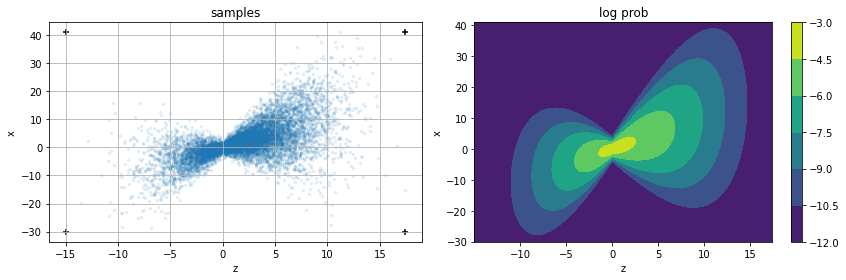

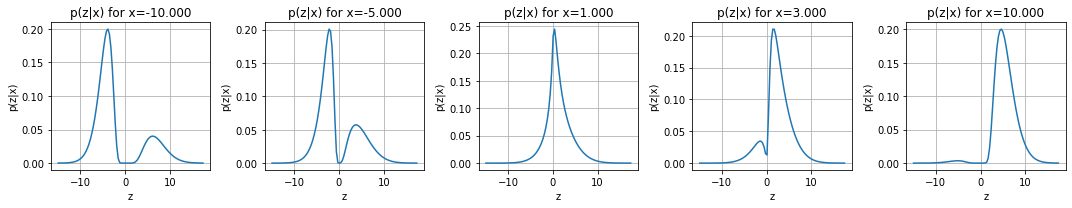

In [37]:
scenario = ScenarioDependantGaussian()
scenario = ScenarioMultiModal()
scenario.plot()
scenario.plot_pz_given_x(xis = [-10, -5,1,3,10])

# Chain sampling

We do the following process

1. Make one observation $x_i$
2. Take one sample $z_i$ from $p(z|x_i)$
3. Take one sample $\hat{x}_i$ from $p(x|z_i)$
4. Go to 2 many times

We will endup with a bunch of samples $\hat{x}$. In general, in this scenario (there are no design choices), there is no particular relation between $x_i$ and the distribution of $\hat{x}$. You can see that in the experiment below.

When we will see the variational autoencoders, we will see that $p(x|z)$ and $p(z|x)$ **are designed** so that $x_i$ is the MLE of $\hat{x}$ and we can reconstruct input data from the distributions of latent variables.

In the experiment below we use [Inverse Transform Sampling](https://en.wikipedia.org/wiki/Inverse_transform_sampling) by using the numerical CDF of each distribution.

In [57]:
observed_xi=-5


In [29]:
scenario.plot_pz_given_xi(observed_xi = -5)

 10% (530 of 5000) |##                   | Elapsed Time: 0:00:09 ETA:   0:01:32

KeyboardInterrupt: ignored

# Estimate $p(z|x_i)$ 

Above we used analytic/numerical methods to compute the different distributions. In almost all practical cases this is not possible and we need to resort to other methods.

We now estimate $p(z|x_i)$ with:

- MCMC
- Variational Inference using a 1D Gaussian class of distributions.
- Variational Inference using a 1D mixture of $n$ Gaussians class of distributions.

note that for

- for $observed_x=-10$ all three methods have difficulty
- for $observed_x=-5$ only VI on a mixture of gaussians produces a decent approximation

##  Estimate $p(z|x_i)$ with MCMC



In [58]:
num_results = 50000
num_burnin_steps = 10000
observed_x = -5
print (observed_x)

-5


In [59]:
# Improve performance by tracing the sampler using `tf.function`
# and compiling it using XLA.
@tf.function(autograph=False, jit_compile=True)
def do_sampling():
  return tfp.mcmc.sample_chain(
                      num_results=num_results,
                      num_burnin_steps=num_burnin_steps,
                      current_state=[
                          tf.constant([-5.], dtype=tf.float32,  name='init_avg_effect'),
                      ],
                      kernel=tfp.mcmc.HamiltonianMonteCarlo(
                          target_log_prob_fn=lambda z: scenario.zx_joint.log_prob((z, observed_x)),
                          step_size=3,
                          num_leapfrog_steps=20)
  )

states, kernel_results = do_sampling()
num_accepted = np.sum(kernel_results.is_accepted)
print('Acceptance rate: {}'.format(num_accepted / num_results))

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


Acceptance rate: 0.13998


Text(0.5, 0, 'a')

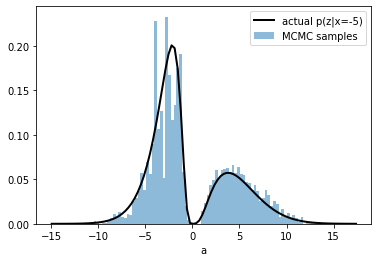

In [60]:
plt.plot(scenario.zr, scenario.pz_given_x(scenario.zr,observed_x), color="black",  lw=2, label=f"actual p(z|x={observed_x})")
plt.hist(states[0].numpy(), alpha=.5, bins=100, density=True, label="MCMC samples");
plt.legend()
plt.xlabel("a")


## Estimate $p(z|x_i)$ with variational inference and a Gaussian class of distributions



We want to find $p(z|x_i)$ given a certain observation $x_i$.

We do this by:

1. define a class of distributions $Q(z|x_i) = \{q_\theta(z|x_i)\}$ parametrized by $\theta$ hoping some distribution of this class is able to approximate $p(z|x_i)$
2. find the parameters $w$ corresponding to the distribution $q_w$ which is closer to $p(z|x_i)$ in KLdiv. This is

$$
\text{arg min}_\theta \;\; KL\big[q_\theta(z|x_i)||p(z|x_i)\big] 
$$

This initially seems hard because we **don't know** $p(z|x_i)$ (which is precisely what we want to obtain), so how can be tell how any $q_\theta(z|x_i)$ may be to it?

It turns our that the following expression is a lower bound to $\text{arg min}_\theta$

$$
\text{arg max}_\theta \;\;\mathbb{E}_{q_\theta(z|x_i)} \log p(x_i|z) - KL\big[q_\theta(z|x_i)||p(z)\big] 
$$

which is equivalent to

$$
\text{arg max}_\theta \;\;\mathbb{E}_{q_\theta(z|x_i)} \big[\log p(x_i|z) - \log q_\theta(z|x_i) + \log p(z) \big]
$$


we choose a family of functions assuming a normal distribution for $p(z|x)$, which may be more or less appropriate to each case.

$$q_{\theta=\{\mu, \sigma\}}(z|x_i) = \mathcal{N}(\mu, \text{softplus}(\sigma))$$


In [84]:
class ApproximatePosteriorDistribution:

  def get_qx(self, x_batch):
    raise NotImplementedError()

  def get_trainable_variables(self):
    raise NotImplementedError()

  def set_observed_x(self, observed_x):
    self.observed_x = observed_x
    return self

  def set_scenario(self, scenario):
    self.scenario = scenario
    return self

  def fit(self, batch_size=500, epochs=200):

    lossh = []

    optimizer=tf.keras.optimizers.Adam(learning_rate=0.05)

    for epoch in pbar(range(epochs)):

        with tf.GradientTape() as t:
            qx = self.get_qx()
            elbo_fn = lambda z: tf.math.log(self.scenario.px_given_z(self.observed_x,z)+1e-10) - ( qx.log_prob(z) - tf.math.log(self.scenario.pz(z)+1e-10))
            s = qx.sample(batch_size)
            loss = -tf.reduce_mean(elbo_fn(s))
            
        gradients = t.gradient(loss, self.get_trainable_variables())
        optimizer.apply_gradients(zip(gradients, self.get_trainable_variables()))

        lossh.append(loss.numpy())

    self.lossh = np.r_[lossh]

  def plot_loss(self):
    for ax,i in subplots(2):
      if i==0: plt.plot(self.lossh); plt.title("loss")
      if i==1:
          qx = approximate_distrib.get_qx()
          plt.plot(self.scenario.zr, self.scenario.pz_given_x(self.scenario.zr,self.observed_x), color="black",  lw=2, label=f"actual p(z|x={self.observed_x})")
          plt.plot(self.scenario.zr, qx.prob(self.scenario.zr), color="red", alpha=.5, lw=5, label="VI estimate")
          plt.legend();    

      plt.grid();

In [62]:
class ApproximatePosteriorNormal(ApproximatePosteriorDistribution):

  def __init__(self):
      self.mu = tf.Variable(np.random.random(), dtype=tf.float32)
      self.sigma = tf.Variable(np.random.random()+1e-2, dtype=tf.float32)

  def get_qx(self, x_batch=None):
      scale = tf.math.softplus(self.sigma)+1e-5
      return tfd.Normal(loc=self.mu, scale=scale)

  def get_trainable_variables(self):
      return [self.mu, self.sigma]

In [66]:
approximate_distrib = ApproximatePosteriorNormal().set_scenario(scenario).set_observed_x(observed_x)

In [67]:
approximate_distrib.fit()

100% (200 of 200) |######################| Elapsed Time: 0:00:05 Time:  0:00:05


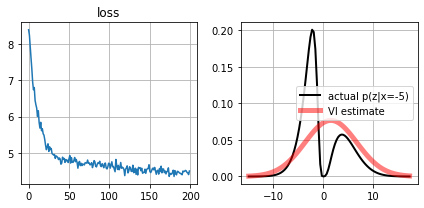

In [68]:
approximate_distrib.plot_loss()

## Estimate $p(z|x_i)$ with variational inference and a mixture of $n$ Gaussians class of distributions


We define

$$
\begin{align}
n & \text{ the number of gaussians in the mixture}\\
\bar{\alpha} = [\alpha_i] &\text{ the weights with which each gaussian participates in the mix}\\
&\text{ with }\sum\alpha_i = 1\text{ and }i \in \{1...n\} \\
\bar{\mu} = [\mu_i] &\text{ the mean of each gaussian}\\
\bar{\sigma} = [\sigma_i] &\text{ the stdev of each gaussian}\\
\end{align}
$$

then our family of distributions is

$$q_{\theta=\{\bar{\mu}, \bar{\sigma},\bar{\alpha}\}}(z|x_i) = \sum \alpha_i \mathcal{N}(\mu_i, \sigma_i)$$

Observe that $\theta=\{\bar{\mu}, \bar{\sigma}, \bar{\alpha}\}$ are the parameters that will be learnt through VI.



In [85]:
class ApproximatePosteriorMixOfNormals(ApproximatePosteriorDistribution):

  def __init__(self, n_gaussians):
    self.n_gaussians = n_gaussians
    self.theta = tf.Variable(np.random.random(size=[n_gaussians,3]), dtype=tf.float32)

  def get_qx(self, x_batch=None):
      return tfd.Mixture(
        cat=tfd.Categorical(logits=self.theta[:,2]),
        components=[tfd.Normal(loc=ti[0], scale=tf.math.softplus(ti[1])) for ti in self.theta]
      )

  def get_trainable_variables(self):
      return [self.theta]

In [86]:
approximate_distrib = ApproximatePosteriorMixOfNormals(n_gaussians=5).set_scenario(scenario).set_observed_x(observed_x)

In [87]:
approximate_distrib.fit(epochs=150, batch_size=100)

100% (150 of 150) |######################| Elapsed Time: 0:00:11 Time:  0:00:11


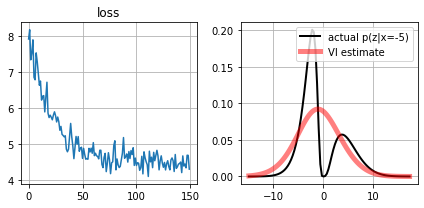

In [88]:
approximate_distrib.plot_loss()